In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

# Исследование для компании "Мегафон"

## Описание данных

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. Ниже вы можете ознакомиться с инфографикой по структуре опроса.

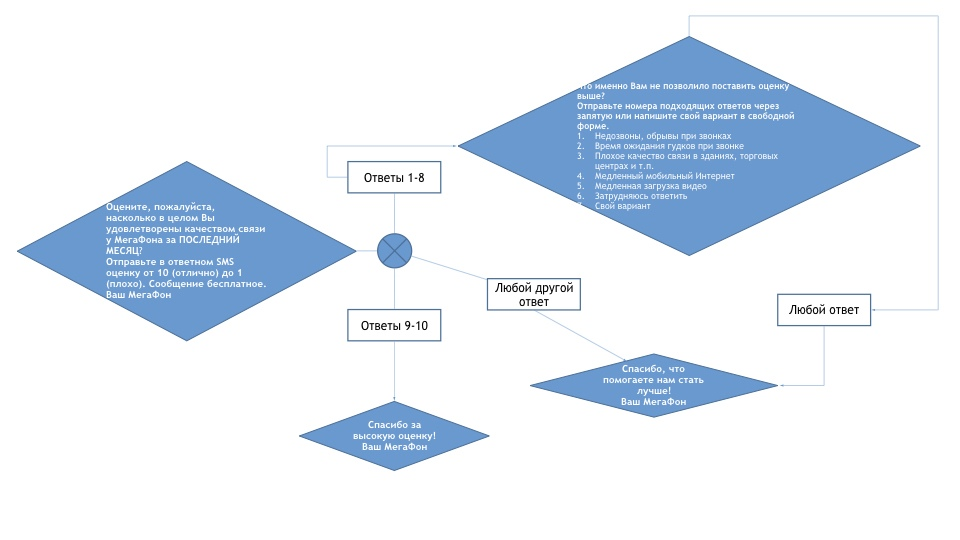

## Задача

Выяснить как зависит (и зависит ли) оценка, которую ставит клиент в опросе, от технических показателей, которые были собраны. 

## Данные

Посмотрим на предоставленные данные:

In [2]:
df = pd.read_csv("megafon.csv")
df.head(3)

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485


Данные представляют из себя набор оценок и технических показателей для нескольких пользователей сети.

## Первый вопрос

Сначала пользователя просят оценить качество связи от 1 до 10

In [3]:
df.dtypes

user_id                                        int64
Q1                                            object
Q2                                            object
Total Traffic(MB)                            float64
Downlink Throughput(Kbps)                    float64
Uplink Throughput(Kbps)                      float64
Downlink TCP Retransmission Rate(%)          float64
Video Streaming Download Throughput(Kbps)    float64
Video Streaming xKB Start Delay(ms)            int64
Web Page Download Throughput(Kbps)           float64
Web Average TCP RTT(ms)                        int64
dtype: object

Как мы видим, ответы на вопросы записаны в виде текста.

In [4]:
# Список допустимых ответов на 1 вопрос
allowed_a1 = [str(a) for a in range(1,11)]

Вот так выглядят несколько примеров неправильных ответов

In [5]:
df[~df.Q1.isin(allowed_a1)].tail()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
2881,2882,Без з,NaN,232.34205,17301.26,181.90,0.08,34732.00,1005,5581.91,114
2972,2973,"10, 5",NaN,324.66015,587.50,194.88,0.63,2063.82,1813,1795.34,130
3013,3014,"2, 5",NaN,240.75223,958.13,81.39,1.63,3656.64,2006,1194.52,83
3026,3027,NaN,NaN,875.62280,7258.66,226.08,0.60,8336.42,1087,3112.83,54
3041,3042,"Я в Смол. Области живу сейчас, не пользуюсь те...",NaN,338.04205,167.67,57.20,1.16,363.19,782,166.81,637


Теперь посмотрим на оценки пользователей...

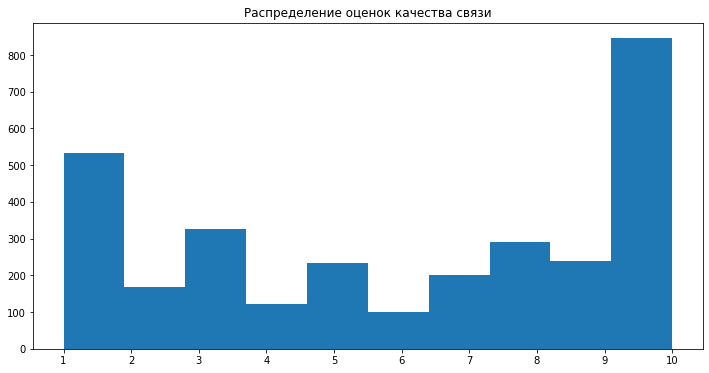

In [6]:
data = df[df.Q1.isin(allowed_a1)].Q1.values.astype(int)

fig, ax = plt.subplots(figsize=(12,6))

ax.hist(data, bins=10)
ax.set_xticks([i for i in range(1,11)])
plt.title("Распределение оценок качества связи")
plt.show()

Уберём мусор из ответов на 1 и 2 вопросы:

In [7]:
df = df[df.Q1.isin(allowed_a1)]

In [8]:
df.Q1 = df.Q1.astype(int)

In [9]:
df = df[df.Q2.notna() | df.Q1.isin([9,10])]

Для оценок связи 9 и 10 поставим в Q2 - `0`

In [10]:
df = df.fillna(0)

## Исследование взаимосвязей

## Для начала исследуем оценку связи и тех показатели

In [11]:
df.corr("pearson").Q1[2:]

Total Traffic(MB)                           -0.003480
Downlink Throughput(Kbps)                    0.086022
Uplink Throughput(Kbps)                      0.064417
Downlink TCP Retransmission Rate(%)         -0.090253
Video Streaming Download Throughput(Kbps)    0.105140
Video Streaming xKB Start Delay(ms)         -0.119985
Web Page Download Throughput(Kbps)           0.075496
Web Average TCP RTT(ms)                     -0.126357
Name: Q1, dtype: float64

Как видно из значений корреляции Пирсона значимой связи между оценкой и тех показателями нет.

Тем не менее попробуем уловить некоторые тренды

Например, узнаем 2 самых значимых показателя

In [12]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [13]:
X = df.iloc[:,3:]

In [14]:
y = list(df.Q1 > 8)

In [15]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
model = clf.fit(X, y)

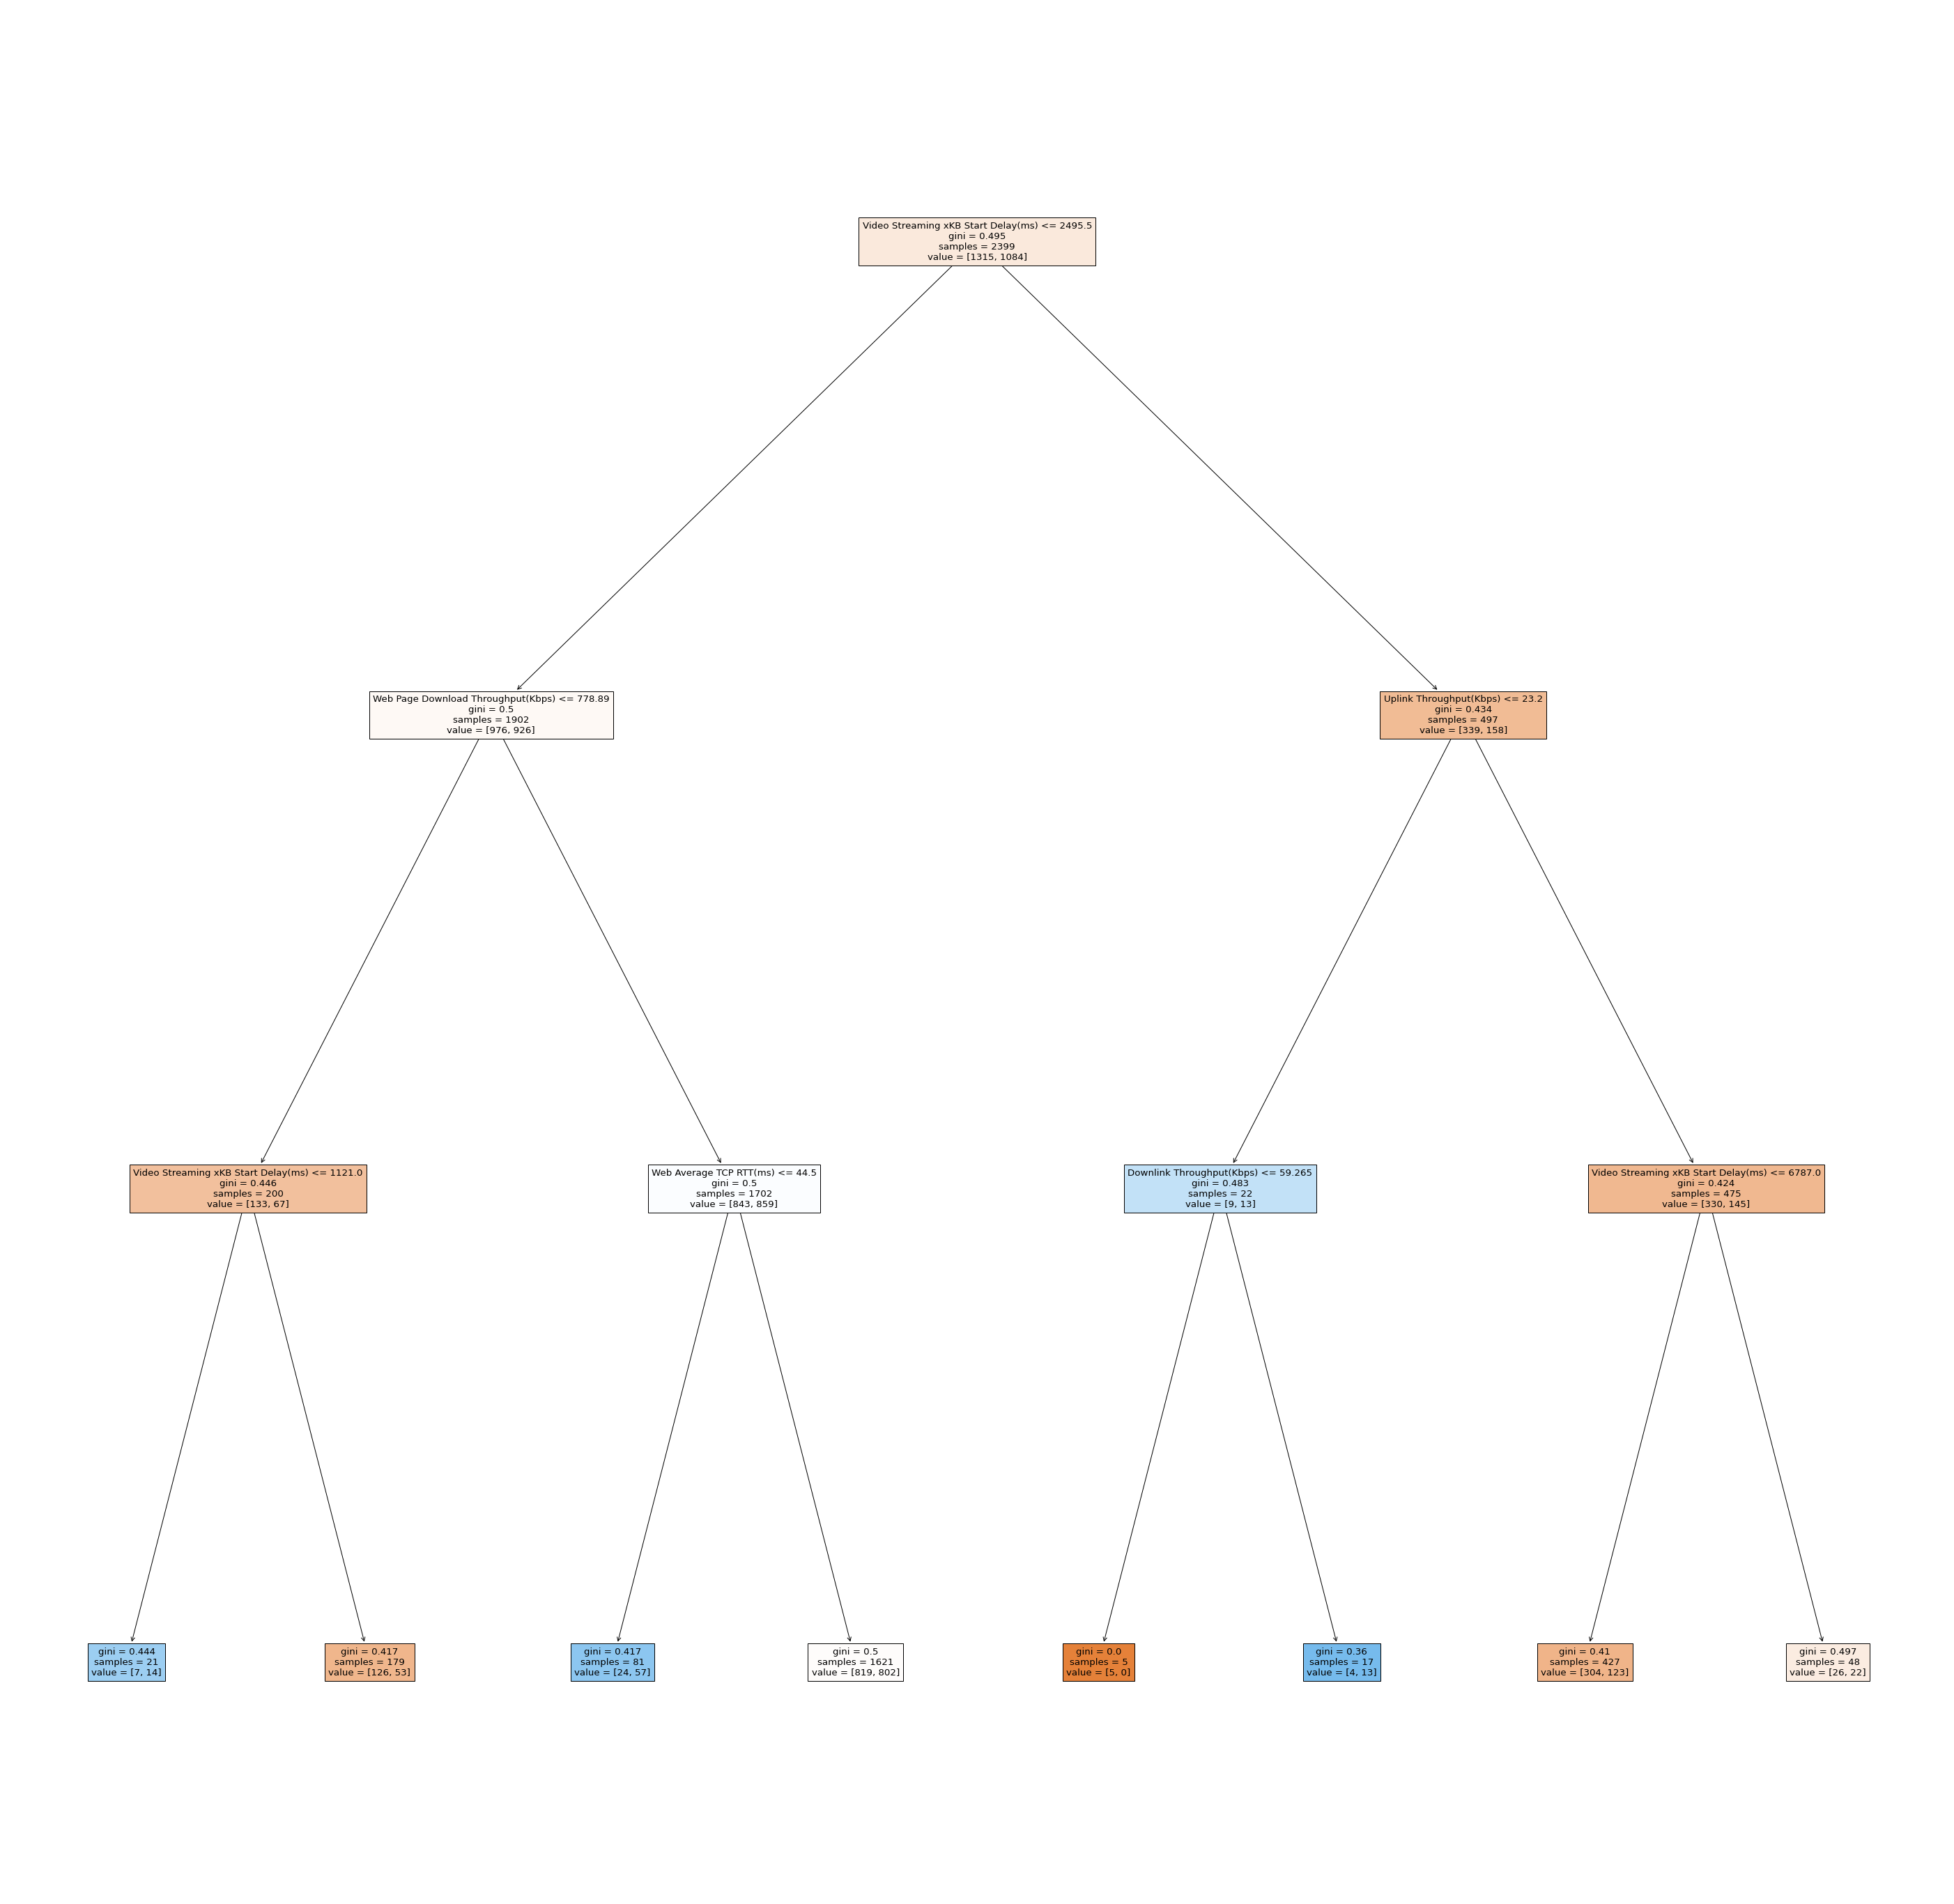

In [16]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   filled=True)
plt.show()

Синими обозначены образцы, в которых классификатор более всего уверен в высокой оценке.

Посмотрев на дерево решений можно сказать, что:
1. Самым значимым признаком для высокой оценки является низкий показатель задержки воспроизведения потокового видео ('Video Streaming xKB Start Delay(ms)').
2. Также для того, чтобы значительно повлиять на оценки пользователей нужно улучшить показатели 'Web Page Download Throughput(Kbps)', 'Uplink Throughput(Kbps)'

## Проверка выводов
Сейчас мы проверим наши выводы, сравнив средние значения для каждого из указанных выше показатей.

`Video Streaming xKB Start Delay(ms)`

Задержка запуска потокового видео. Чем ниже, тем лучше.

In [17]:
df[df.Q1 >= 9]["Video Streaming xKB Start Delay(ms)"].mean()

1919.189114391144

In [18]:
df[df.Q1 < 9]["Video Streaming xKB Start Delay(ms)"].mean()

2277.691254752852

`Web Page Download Throughput(Kbps)`

Пропускная способность загрузки веб-страницы (Чем выше, тем лучше)

In [19]:
df[df.Q1 >= 9]["Web Page Download Throughput(Kbps)"].mean()

2290.297490774908

In [20]:
df[df.Q1 < 9]["Web Page Download Throughput(Kbps)"].mean()

2025.9082433460076

`Uplink Throughput(Kbps)`

Пропускная способность восходящего канала. Чем выше, тем лучше

In [21]:
df[df.Q1 >= 9]["Uplink Throughput(Kbps)"].mean()

182.43023985239853

In [22]:
df[df.Q1 < 9]["Uplink Throughput(Kbps)"].mean()

162.44851711026618

# A/B тестирование

In [23]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st

In [24]:
df["high_score"] = 0

In [25]:
df.loc[(df.Q1 >= 9), "high_score"] = 1

In [26]:
def print_ci(val_arr):
    n = val_arr.size
    p = val_arr.sum() / n
    se = np.sqrt(p * (1 - p) / n)
    ci = st.norm.interval(0.9, loc = p, scale = se)
    print(f"Среднее: {val_arr.mean():.2f}, Доверительный интервал: ({ci[0]:.2f}, {ci[1]:.2f})")

## Гипотеза: Video Streaming xKB Start Delay

In [30]:
par = "Video Streaming xKB Start Delay(ms)"
tresh = 2495.5

high_rates = df[df[par] < tresh]["high_score"].values
low_rates = df[df[par] >= tresh]["high_score"].values

print(f"Параметр: {par}; Пороговое значение: {tresh}")
print("Выборка с высокими оценками")
print_ci(high_rates)
print("Выборка с низкими оценками")
print_ci(low_rates)

Параметр: Video Streaming xKB Start Delay(ms); Пороговое значение: 2495.5
Выборка с высокими оценками
Среднее: 0.49, Доверительный интервал: (0.47, 0.51)
Выборка с низкими оценками
Среднее: 0.32, Доверительный интервал: (0.28, 0.35)


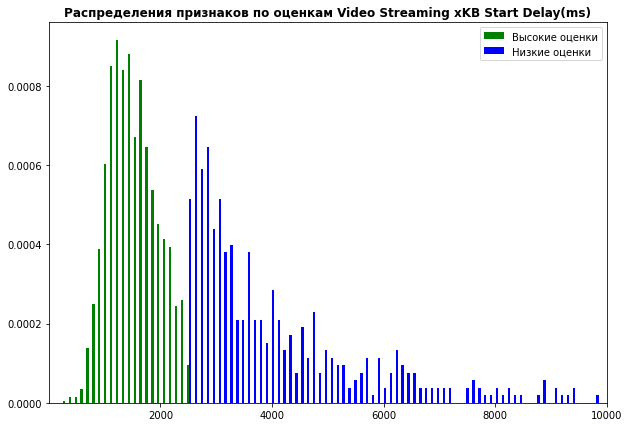

In [55]:
fig, ax = plt.subplots(figsize=(10,7))

np.random.seed(10**7)
n_bins = 200
x = [df[df[par] < tresh][par], df[df[par] >= tresh][par]]
    
colors = ['green', 'blue']
  
plt.hist(x, n_bins, density = True, 
         histtype ='bar',
         color = colors,
         label = ["Высокие оценки", "Низкие оценки"])
plt.legend(prop ={'size': 10})
  
plt.title(f'Распределения признаков по оценкам {par}',
          fontweight ="bold")
plt.xlim(1, 10000)
plt.show()

## Подтверждено
Как видно, если значение меньше порогового, пользователь вероятнее поставит высокую оценку.

## Гипотеза: Web Page Download Throughput

In [70]:
par = "Web Page Download Throughput(Kbps)"
tresh = 779

high_rates = df[df[par] >= tresh]["high_score"].values
low_rates = df[df[par] < tresh]["high_score"].values

print(f"Параметр: {par}; Пороговое значение: {tresh}")
print("Выборка с высокими оценками")
print_ci(high_rates)
print("Выборка с низкими оценками")
print_ci(low_rates)

Параметр: Web Page Download Throughput(Kbps); Пороговое значение: 779
Выборка с высокими оценками
Среднее: 0.48, Доверительный интервал: (0.46, 0.50)
Выборка с низкими оценками
Среднее: 0.32, Доверительный интервал: (0.28, 0.35)


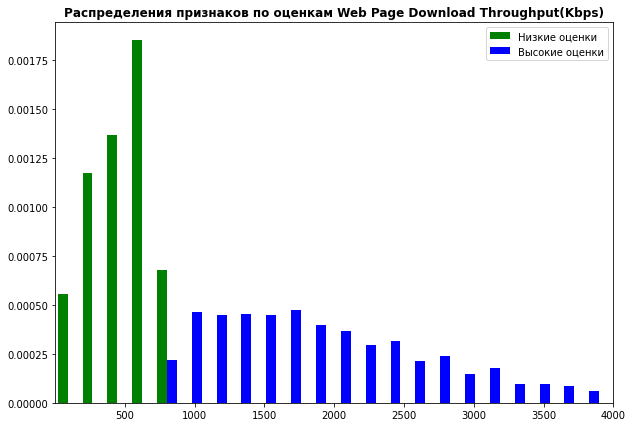

In [71]:
fig, ax = plt.subplots(figsize=(10,7))

np.random.seed(10**7)
n_bins = 200
x = [df[df[par] < tresh][par], df[df[par] >= tresh][par]]
    
colors = ['green', 'blue']
  
plt.hist(x, n_bins, density = True, 
         histtype ='bar',
         color = colors,
         label = ["Низкие оценки", "Высокие оценки"])
plt.legend(prop ={'size': 10})
  
plt.title(f'Распределения признаков по оценкам {par}',
          fontweight ="bold")
plt.xlim(1, 4000)
plt.show()

## Подтверждено
Как видно, если значение больше порогового, пользователь вероятнее поставит высокую оценку.

## Гипотеза: Uplink Throughput

In [72]:
par = "Uplink Throughput(Kbps)"
tresh = 23.2

high_rates = df[df[par] >= tresh]["high_score"].values
low_rates = df[df[par] < tresh]["high_score"].values

print(f"Параметр: {par}; Пороговое значение: {tresh}")
print("Выборка с высокими оценками")
print_ci(high_rates)
print("Выборка с низкими оценками")
print_ci(low_rates)

Параметр: Uplink Throughput(Kbps); Пороговое значение: 23.2
Выборка с высокими оценками
Среднее: 0.45, Доверительный интервал: (0.43, 0.47)
Выборка с низкими оценками
Среднее: 0.53, Доверительный интервал: (0.42, 0.64)


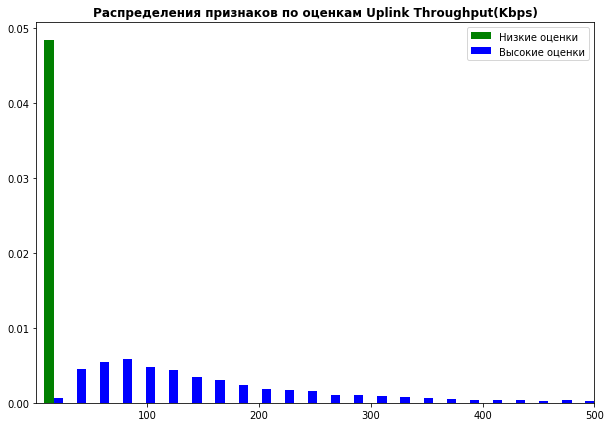

In [73]:
fig, ax = plt.subplots(figsize=(10,7))

np.random.seed(10**7)
n_bins = 200
x = [df[df[par] < tresh][par], df[df[par] >= tresh][par]]
    
colors = ['green', 'blue']
  
plt.hist(x, n_bins, density = True, 
         histtype ='bar',
         color = colors,
         label = ["Низкие оценки", "Высокие оценки"])
plt.legend(prop ={'size': 10})
  
plt.title(f'Распределения признаков по оценкам {par}',
          fontweight ="bold")
plt.xlim(1, 500)
plt.show()

## НЕ подтверждено
Доверительные интервалы пересекаются...

# Итоги

1. Корелляционный анализ показал, что зависимость тех показателей и оценок пользователей незначительная.
2. С помощью алгоритма машинного обучения было выяснено, что самым важным показателем является `Video Streaming xKB Start Delay(ms)`